In [9]:
import os, torch, numpy as np, pandas as pd
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from PIL import Image
from tqdm.auto import tqdm
from sklearn.metrics import f1_score, classification_report

# ======================================================
# PATHS
# ======================================================

TEST_PATH = "/kaggle/input/datasets/himanshurajput123/rare-events-71-80"
MODEL_PATH = "/kaggle/input/datasets/harshit1631/best-model-maybe-1/final_model.pth"

CSV_DIR = os.path.join(TEST_PATH,"CSVs")
IMG_DIR = os.path.join(TEST_PATH,"Images")

# ======================================================
# LABELS
# ======================================================

disease_cols = [
"ulcer","polyp","active bleeding","blood","erythema",
"erosion","angiectasia","IBD","foreign body","esophagitis",
"varices","hematin","celiac","cancer","lymphangioectasis"
]

num_classes=len(disease_cols)
device="cuda" if torch.cuda.is_available() else "cpu"

print("Device:",device)

# ======================================================
# TRANSFORM
# ======================================================

transform = transforms.Compose([
    transforms.Resize((300,300)),
    transforms.ToTensor()
])

# ======================================================
# MODEL ARCHITECTURES
# ======================================================

def get_model(name):

    if name=="efficientnet":
        m=models.efficientnet_b3(weights=None)
        m.classifier[1]=nn.Linear(m.classifier[1].in_features,num_classes)

    elif name=="resnet":
        m=models.resnet50(weights=None)
        m.fc=nn.Linear(m.fc.in_features,num_classes)

    else:
        m=models.densenet121(weights=None)
        m.classifier=nn.Linear(m.classifier.in_features,num_classes)

    return m.to(device)

models_list=[
    get_model("efficientnet"),
    get_model("resnet"),
    get_model("densenet")
]

# ======================================================
# LOAD MODEL
# ======================================================

states=torch.load(MODEL_PATH,map_location=device)

for m,s in zip(models_list,states):
    m.load_state_dict(s)
    m.eval()

print("Models loaded successfully")

# ======================================================
# PREDICTION FUNCTION
# ======================================================

def predict_image(path):

    img=Image.open(path).convert("RGB")
    img=transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        outs=[torch.sigmoid(m(img)) for m in models_list]
        avg=torch.mean(torch.stack(outs),0)

    return avg.cpu().numpy()[0]

# ======================================================
# TEST LOOP
# ======================================================

all_preds=[]
all_targets=[]

patients=[f.replace(".csv","") for f in os.listdir(CSV_DIR)]

for pid in tqdm(patients):

    df=pd.read_csv(os.path.join(CSV_DIR,f"{pid}.csv"))

    for _,row in df.iterrows():

        frame=int(row["frame"])
        img_name=f"frame_{frame:06d}.PNG"
        img_path=os.path.join(IMG_DIR,pid,img_name)

        if not os.path.exists(img_path):
            continue

        pred=predict_image(img_path)

        all_preds.append(pred)
        all_targets.append(row[disease_cols].values.astype(int))

# convert to arrays
all_preds=np.array(all_preds)
all_targets=np.array(all_targets)

print("Predictions complete")
print("Total samples:",len(all_preds))

# ======================================================
# THRESHOLD + METRICS
# ======================================================

THRESHOLD = 0.3   # better for medical datasets
binary=(all_preds>THRESHOLD).astype(int)

print("\n==============================")
print("Macro F1:", f1_score(all_targets,binary,average="macro"))
print("==============================\n")

print("Per-class F1:")
print(f1_score(all_targets,binary,average=None))

print("\nDetailed Report:\n")
print(classification_report(all_targets,binary,target_names=disease_cols,zero_division=0))

Device: cuda
Models loaded successfully


  0%|          | 0/10 [00:00<?, ?it/s]

Predictions complete
Total samples: 31635

Macro F1: 0.08893485739808614

Per-class F1:
[0.         0.00564573 0.11522634 0.30717381 0.18819645 0.02599388
 0.36617199 0.         0.         0.         0.         0.30013446
 0.         0.         0.0254802 ]

Detailed Report:

                   precision    recall  f1-score   support

            ulcer       0.00      0.00      0.00         7
            polyp       0.00      0.01      0.01       480
  active bleeding       0.20      0.08      0.12       173
            blood       0.33      0.29      0.31      1098
         erythema       0.12      0.42      0.19       544
          erosion       0.04      0.02      0.03       928
      angiectasia       0.28      0.51      0.37      8766
              IBD       0.00      0.00      0.00         0
     foreign body       0.00      0.00      0.00         0
      esophagitis       0.00      0.00      0.00         0
          varices       0.00      0.00      0.00         0
          hemat

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [1]:
import os, torch, numpy as np, pandas as pd
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from PIL import Image
from tqdm.auto import tqdm
from sklearn.metrics import f1_score, classification_report

# ======================================================
# PATHS
# ======================================================
TEST_PATH="/kaggle/input/datasets/himanshurajput123/rare-events-71-80"
MODEL_PATH="/kaggle/input/datasets/harshit1631/best-model-maybe-1/final_model.pth"

CSV_DIR=os.path.join(TEST_PATH,"CSVs")
IMG_DIR=os.path.join(TEST_PATH,"Images")

# ======================================================
# SETTINGS
# ======================================================
BATCH_SIZE=32
THRESHOLD=0.3
device="cuda" if torch.cuda.is_available() else "cpu"

print("Device:",device)

# ======================================================
# LABELS
# ======================================================
disease_cols=[
"ulcer","polyp","active bleeding","blood","erythema",
"erosion","angiectasia","IBD","foreign body","esophagitis",
"varices","hematin","celiac","cancer","lymphangioectasis"
]
num_classes=len(disease_cols)

# ======================================================
# TRANSFORM
# ======================================================
transform=transforms.Compose([
    transforms.Resize((300,300)),
    transforms.ToTensor()
])

# ======================================================
# MODELS
# ======================================================
def get_model(name):

    if name=="efficientnet":
        m=models.efficientnet_b3(weights=None)
        m.classifier[1]=nn.Linear(m.classifier[1].in_features,num_classes)

    elif name=="resnet":
        m=models.resnet50(weights=None)
        m.fc=nn.Linear(m.fc.in_features,num_classes)

    else:
        m=models.densenet121(weights=None)
        m.classifier=nn.Linear(m.classifier.in_features,num_classes)

    return m.to(device)

models_list=[
    get_model("efficientnet"),
    get_model("resnet"),
    get_model("densenet")
]

# ======================================================
# LOAD MODEL
# ======================================================
states=torch.load(MODEL_PATH,map_location=device)

for m,s in zip(models_list,states):
    m.load_state_dict(s)
    m.eval()

print("Models loaded")

# ======================================================
# TEST LOOP (BATCHED + FAST)
# ======================================================
all_preds=[]
all_targets=[]

patients=[f.replace(".csv","") for f in os.listdir(CSV_DIR)]

for pid in tqdm(patients):

    df=pd.read_csv(os.path.join(CSV_DIR,f"{pid}.csv"))

    imgs=[]
    labels=[]

    for _,row in df.iterrows():

        frame=int(row["frame"])
        path=os.path.join(IMG_DIR,pid,f"frame_{frame:06d}.PNG")

        if not os.path.exists(path):
            continue

        img=Image.open(path).convert("RGB")
        imgs.append(transform(img))
        labels.append(row[disease_cols].values.astype(int))

        if len(imgs)==BATCH_SIZE:

            batch=torch.stack(imgs).to(device)

            with torch.no_grad():
                outs=[torch.sigmoid(m(batch)) for m in models_list]
                avg=torch.mean(torch.stack(outs),0)

            all_preds.extend(avg.cpu().numpy())
            all_targets.extend(labels)

            imgs=[]
            labels=[]

    # leftover batch
    if imgs:
        batch=torch.stack(imgs).to(device)

        with torch.no_grad():
            outs=[torch.sigmoid(m(batch)) for m in models_list]
            avg=torch.mean(torch.stack(outs),0)

        all_preds.extend(avg.cpu().numpy())
        all_targets.extend(labels)

# ======================================================
# METRICS
# ======================================================
all_preds=np.array(all_preds)
all_targets=np.array(all_targets)

binary=(all_preds>THRESHOLD).astype(int)

print("\n========================")
print("Total samples:",len(all_preds))
print("Macro F1:",f1_score(all_targets,binary,average="macro"))
print("========================\n")

print("Per-class F1:")
print(f1_score(all_targets,binary,average=None))

print("\nDetailed Report:\n")
print(classification_report(all_targets,binary,target_names=disease_cols,zero_division=0))

Device: cuda
Models loaded


  0%|          | 0/10 [00:00<?, ?it/s]


Total samples: 31635
Macro F1: 0.08893485739808614

Per-class F1:
[0.         0.00564573 0.11522634 0.30717381 0.18819645 0.02599388
 0.36617199 0.         0.         0.         0.         0.30013446
 0.         0.         0.0254802 ]

Detailed Report:

                   precision    recall  f1-score   support

            ulcer       0.00      0.00      0.00         7
            polyp       0.00      0.01      0.01       480
  active bleeding       0.20      0.08      0.12       173
            blood       0.33      0.29      0.31      1098
         erythema       0.12      0.42      0.19       544
          erosion       0.04      0.02      0.03       928
      angiectasia       0.28      0.51      0.37      8766
              IBD       0.00      0.00      0.00         0
     foreign body       0.00      0.00      0.00         0
      esophagitis       0.00      0.00      0.00         0
          varices       0.00      0.00      0.00         0
          hematin       0.26      0.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Samples: 31635
Classes: 15


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


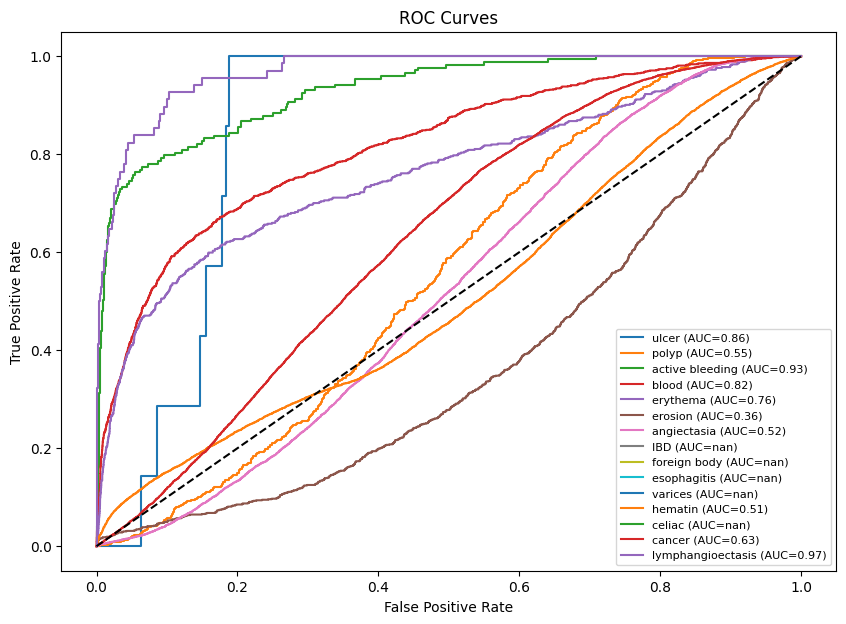

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


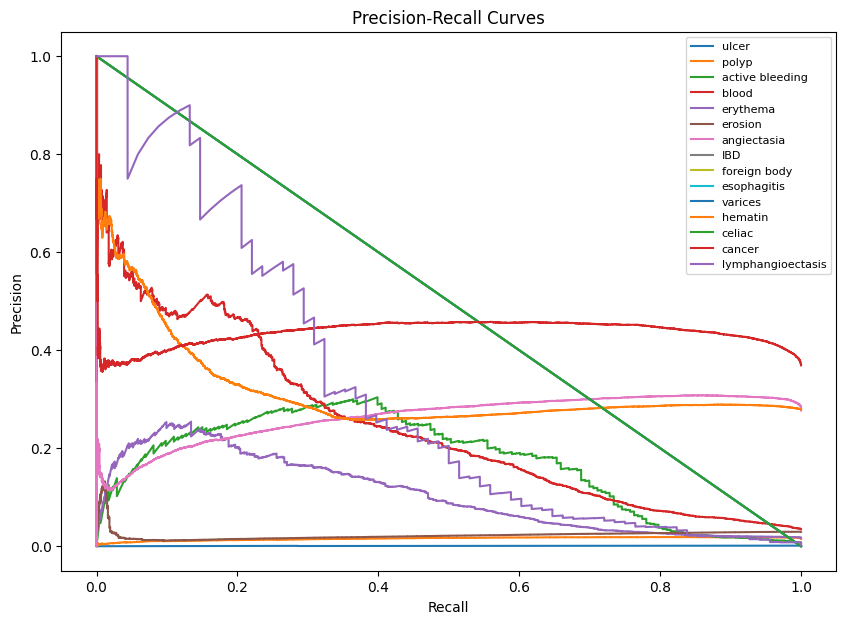

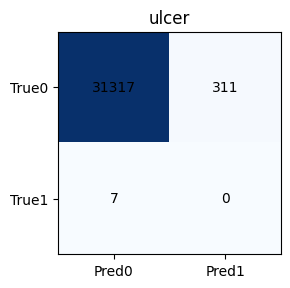

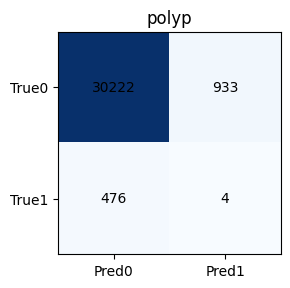

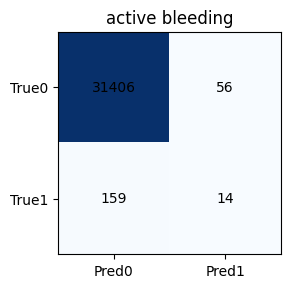

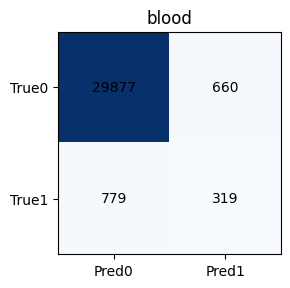

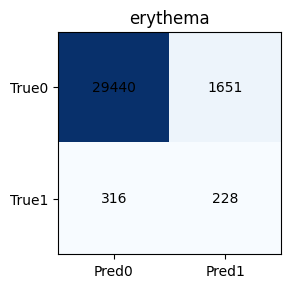

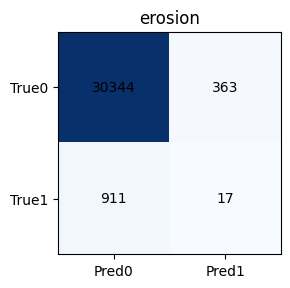

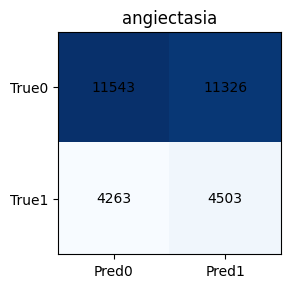

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


IndexError: index 1 is out of bounds for axis 1 with size 1

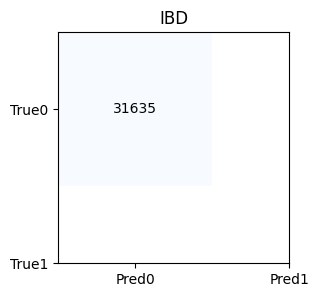

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix

# ============================================
# BASIC INFO
# ============================================
print("Samples:", len(all_preds))
print("Classes:", len(disease_cols))

# ============================================
# ROC CURVES
# ============================================
plt.figure(figsize=(10,7))

for i,name in enumerate(disease_cols):
    fpr,tpr,_=roc_curve(all_targets[:,i],all_preds[:,i])
    plt.plot(fpr,tpr,label=f"{name} (AUC={auc(fpr,tpr):.2f})")

plt.plot([0,1],[0,1],'k--')
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(fontsize=8)
plt.show()

# ============================================
# PRECISION-RECALL CURVES
# ============================================
plt.figure(figsize=(10,7))

for i,name in enumerate(disease_cols):
    p,r,_=precision_recall_curve(all_targets[:,i],all_preds[:,i])
    plt.plot(r,p,label=name)

plt.title("Precision-Recall Curves")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(fontsize=8)
plt.show()

# ============================================
# PER CLASS CONFUSION MATRICES
# ============================================
for i,name in enumerate(disease_cols):

    cm=confusion_matrix(all_targets[:,i],(all_preds[:,i]>THRESHOLD).astype(int))

    plt.figure(figsize=(3,3))
    plt.imshow(cm,cmap="Blues")
    plt.title(name)
    plt.xticks([0,1],["Pred0","Pred1"])
    plt.yticks([0,1],["True0","True1"])

    for x in range(2):
        for y in range(2):
            plt.text(y,x,cm[x,y],ha="center",va="center")

    plt.tight_layout()
    plt.show()

# ============================================
# CONFIDENCE ANALYSIS
# ============================================
confidence = np.max(all_preds,axis=1)

print("\nConfidence stats:")
print("Mean:",confidence.mean())
print("Min:",confidence.min())
print("Max:",confidence.max())

# ============================================
# HARDEST SAMPLES
# ============================================
errors = np.abs(all_targets-all_preds).mean(axis=1)
hard_idx = np.argsort(errors)[-10:]

print("\nHardest samples indices:")
print(hard_idx)

# ============================================
# EASIEST SAMPLES
# ============================================
easy_idx = np.argsort(errors)[:10]

print("\nEasiest samples indices:")
print(easy_idx)

In [4]:
for t in [0.5,0.3,0.2,0.15,0.1]:
    binary=(all_preds>t).astype(int)
    print(t, f1_score(all_targets,binary,average="macro"))

0.5 0.0717930643161819
0.3 0.08893485739808614
0.2 0.09511347474660421
0.15 0.0986773390024434
0.1 0.10401457503882701


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/di

In [5]:
for t in np.arange(0.01,0.11,0.01):
    binary=(all_preds>t).astype(int)
    print(round(t,2), f1_score(all_targets,binary,average="macro"))

0.01 0.09641737037643261
0.02 0.10122318500514876
0.03 0.10266343150475896
0.04 0.10491298598047213
0.05 0.10481361997440607
0.06 0.10603072265751033
0.07 0.10628079820558495
0.08 0.10692972747704707
0.09 0.10575148151658859
0.1 0.10401457503882701


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/di

In [6]:

import numpy as np
from sklearn.metrics import f1_score

print("Searching best threshold per class...\n")

best_thresholds=[]
best_scores=[]

for i,name in enumerate(disease_cols):

    best_t=0
    best_f1=0

    for t in np.arange(0.01,0.51,0.01):

        preds=(all_preds[:,i]>t).astype(int)
        f1=f1_score(all_targets[:,i],preds,zero_division=0)

        if f1>best_f1:
            best_f1=f1
            best_t=t

    best_thresholds.append(best_t)
    best_scores.append(best_f1)

    print(f"{name:20s}  best_t={best_t:.2f}   f1={best_f1:.3f}")

# =========================================
# APPLY PER-CLASS THRESHOLDS
# =========================================

binary=np.zeros_like(all_preds)

for i,t in enumerate(best_thresholds):
    binary[:,i]=(all_preds[:,i]>t).astype(int)

macro=f1_score(all_targets,binary,average="macro")

print("\n==============================")
print("NEW Macro F1:",macro)
print("==============================")

# improvement
old_macro=f1_score(all_targets,(all_preds>0.08).astype(int),average="macro")

print("\nImprovement over global threshold:")
print("Old:",old_macro)
print("New:",macro)
print("Gain:",macro-old_macro)

Searching best threshold per class...

ulcer                 best_t=0.01   f1=0.001
polyp                 best_t=0.01   f1=0.026
active bleeding       best_t=0.08   f1=0.342
blood                 best_t=0.30   f1=0.307
erythema              best_t=0.49   f1=0.215
erosion               best_t=0.31   f1=0.027
angiectasia           best_t=0.02   f1=0.460
IBD                   best_t=0.00   f1=0.000
foreign body          best_t=0.00   f1=0.000
esophagitis           best_t=0.00   f1=0.000
varices               best_t=0.00   f1=0.000
hematin               best_t=0.01   f1=0.405
celiac                best_t=0.00   f1=0.000
cancer                best_t=0.01   f1=0.001
lymphangioectasis     best_t=0.50   f1=0.045

NEW Macro F1: 0.12200204945320935

Improvement over global threshold:
Old: 0.10692972747704707
New: 0.12200204945320935
Gain: 0.015072321976162276


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [7]:
import numpy as np
from sklearn.metrics import f1_score, classification_report

# =========================================
# REMOVE CANCER CLASS
# =========================================

exclude_class = "cancer"
idx = disease_cols.index(exclude_class)

# remove column
preds = np.delete(all_preds, idx, axis=1)
targets = np.delete(all_targets, idx, axis=1)

# updated label names
new_labels = [c for c in disease_cols if c != exclude_class]

print("Removed class:", exclude_class)
print("Remaining classes:", len(new_labels))

# =========================================
# THRESHOLD (use best global threshold)
# =========================================

THRESHOLD = 0.08
binary = (preds > THRESHOLD).astype(int)

# =========================================
# METRICS
# =========================================

print("\n============================")
print("Macro F1 (no cancer):", f1_score(targets, binary, average="macro"))
print("============================\n")

print("Per-class F1:")
print(f1_score(targets, binary, average=None))

print("\nDetailed Report:\n")
print(classification_report(targets, binary, target_names=new_labels, zero_division=0))""

SyntaxError: invalid syntax (4200092685.py, line 40)

In [8]:
import numpy as np
from sklearn.metrics import f1_score, classification_report

# =========================================
# REMOVE CANCER CLASS
# =========================================

exclude_class = "cancer"
idx = disease_cols.index(exclude_class)

preds = np.delete(all_preds, idx, axis=1)
targets = np.delete(all_targets, idx, axis=1)

new_labels = [c for c in disease_cols if c != exclude_class]

print("Removed class:", exclude_class)
print("Remaining classes:", len(new_labels))

# =========================================
# THRESHOLD
# =========================================

THRESHOLD = 0.08
binary = (preds > THRESHOLD).astype(int)

# =========================================
# METRICS
# =========================================

print("\n============================")
print("Macro F1 (no cancer):", f1_score(targets, binary, average="macro"))
print("============================\n")

print("Per-class F1:")
print(f1_score(targets, binary, average=None))

print("\nDetailed Report:\n")
print(classification_report(targets, binary, target_names=new_labels, zero_division=0))

Removed class: cancer
Remaining classes: 14

Macro F1 (no cancer): 0.114567565153979

Per-class F1:
[0.         0.01774848 0.34243176 0.29746282 0.10928595 0.02285714
 0.45157764 0.         0.         0.         0.         0.34821946
 0.         0.01436266]

Detailed Report:

                   precision    recall  f1-score   support

            ulcer       0.00      0.00      0.00         7
            polyp       0.01      0.07      0.02       480
  active bleeding       0.30      0.40      0.34       173
            blood       0.22      0.46      0.30      1098
         erythema       0.06      0.60      0.11       544
          erosion       0.02      0.04      0.02       928
      angiectasia       0.31      0.85      0.45      8766
              IBD       0.00      0.00      0.00         0
     foreign body       0.00      0.00      0.00         0
      esophagitis       0.00      0.00      0.00         0
          varices       0.00      0.00      0.00         0
          hema

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
